# CNN training on entire CNV by 3 classes

In [1]:
import os
import re
import sys
import copy
import random
import datetime
import timeit
import pdb

import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

from __future__ import print_function
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

sys.path.append('/home/rt2776/cnv_espresso/src')
import function_dl as func_dl
import function as func

%load_ext autoreload
%autoreload 2

Tensorflow version 2.2.0
Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
img_width, img_height = 224, 224
seed = 2021

## Importing data from scratch

### Declare project's folder

In [4]:
project_dir     = '/home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY/'
data_backup_dir = project_dir + '/data_backup/'
model_dir       = project_dir + '/model_h5/'
figure_path     = project_dir + '/figures/'

### Import file path

In [ ]:
## For rare CNVs
# path = '/home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/0-entire_cnv_file_list'
# true_del_file  = path + 'true_del_image_info.list'
# false_del_file = path + 'false_del_image_info.list'

# true_dup_file  = path + 'true_dup_image_info.list'
# false_dup_file = path + 'false_dup_image_info.list'

# true_del_df  = pd.read_csv(true_del_file,  header=0,sep='\t')
# false_del_df = pd.read_csv(false_del_file, header=0,sep='\t')

# true_dup_df  = pd.read_csv(true_dup_file,  header=0,sep='\t')
# false_dup_df = pd.read_csv(false_dup_file, header=0,sep='\t')

# true_del_images_path_list  = true_del_df['image_path']
# false_del_images_path_list = false_del_df['image_path']

# true_dup_images_path_list  = true_dup_df['image_path']
# false_dup_images_path_list = false_dup_df['image_path']

##----------------------------------------------------------------------------
## [update 2021.09.20] train the model by log transformed images
path = '/home/rt2776/cnv_espresso/project0_train_model/'
true_del_file  = path + 'logDiffCumX_logY_true_del/cnv_info_w_img.csv'
true_dup_file  = path + 'logDiffCumX_logY_true_dup/cnv_info_w_img.csv'
false_del_file = path + 'logDiffCumX_logY_false_del/cnv_info_w_img.csv'
false_dup_file = path + 'logDiffCumX_logY_false_dup/cnv_info_w_img.csv'

true_del_df    = pd.read_csv(true_del_file,  header=0)
true_dup_df    = pd.read_csv(true_dup_file,  header=0)
false_del_df   = pd.read_csv(false_del_file, header=0)
false_dup_df   = pd.read_csv(false_dup_file, header=0)

true_del_images_path_list  = true_del_df['img_path']
true_dup_images_path_list  = true_dup_df['img_path']
false_del_images_path_list = false_del_df['img_path']
false_dup_images_path_list = false_dup_df['img_path']

In [ ]:
true_del_images_path_list.shape, false_del_images_path_list.shape, true_dup_images_path_list.shape, false_dup_images_path_list.shape

### Loading images from list to numpy array

In [ ]:
# # entire cnv
true_del_img_np  = func_dl.loadImgs(true_del_images_path_list,  img_width, img_height)
true_dup_img_np  = func_dl.loadImgs(true_dup_images_path_list,  img_width, img_height)
false_del_img_np = func_dl.loadImgs(false_del_images_path_list, img_width, img_height)
false_dup_img_np = func_dl.loadImgs(false_dup_images_path_list, img_width, img_height)

true_del_img_np.shape, true_dup_img_np.shape, false_del_img_np.shape, false_dup_img_np.shape

### Generate labels for entire CNVs

In [ ]:
# # Four classes
# true_del_label = [0 for i in range(0,len(true_del_img_np))]
# false_del_label = [1 for i in range(0,len(false_del_img_np))]

# true_dup_label = [3 for i in range(0,len(true_dup_img_np))]
# false_dup_label = [2 for i in range(0,len(false_dup_img_np))]

# print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
# print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

In [ ]:
# Three classes
true_del_label  = [0 for i in range(0,len(true_del_img_np))]
true_dup_label  = [2 for i in range(0,len(true_dup_img_np))]
false_del_label = [1 for i in range(0,len(false_del_img_np))]
false_dup_label = [1 for i in range(0,len(false_dup_img_np))]

print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

### Combine true & false data for entire CNVs

In [ ]:
combined_cnv_info_df = true_del_df.append(false_del_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(true_dup_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(false_dup_df, ignore_index=True)

In [ ]:
combined_img_np = np.vstack((true_del_img_np, false_del_img_np, true_dup_img_np, false_dup_img_np))
combined_img_np.shape

In [ ]:
combined_label = true_del_label + false_del_label + true_dup_label + false_dup_label
len(combined_label)

## Backup or restore data

- Backup

In [ ]:
## Original
# backup_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/' 

## log transformed version
backup_path = '/home/rt2776/cnv_espresso/project0_train_model/data_backup_logDiffCumX_logY/'
os.makedirs(backup_path, exist_ok=True)

project_name = 'rare_entire_del'
combined_cnv_info_df.to_csv(backup_path+'rare_entire_del_info.csv')
np.save(backup_path+'rare_entire_del_img', combined_img_np)
np.save(backup_path+'rare_entire_del_label', combined_label)

project_name = 'rare_entire_dup'
combined_cnv_info_df.to_csv(backup_path+'rare_entire_dup_info.csv')
np.save(backup_path+'rare_entire_dup_img', combined_img_np)
np.save(backup_path+'rare_entire_dup_label', combined_label)

project_name = 'rare_entire_cnv'
combined_cnv_info_df.to_csv(backup_path+'rare_entire_cnv_info.csv')
np.save(backup_path+'rare_entire_cnv_img', combined_img_np)
np.save(backup_path+'rare_entire_cnv_label_'+str(len(np.unique(combined_label)))+'classes', combined_label)

- Restore

In [5]:
# backup_path = '/home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/data_backup/'
print(data_backup_dir)
# ## Restore for entire del or dup

# # project_name = 'rare_entire_del'
# # project_name = 'rare_entire_dup'
project_name = 'rare_entire_cnv'
nClasses = 3
if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup' or project_name == 'rare_entire_cnv':
    combined_img = np.load(data_backup_dir + project_name + '_img.npy')
    combined_label = np.load(data_backup_dir+'rare_entire_cnv_label_'+str(nClasses)+'classes'+ '.npy')
    combined_cnv_info_df = pd.read_csv(data_backup_dir+project_name+'_info.csv')

/home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//data_backup/


In [6]:
print("Project: '%s' dataset loaded."%project_name)
print("  -- Shape of image array: ", combined_img.shape)
print("  -- Lenghth/shape of label: ", len(combined_label))
try:
    print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)
except:
    print("There is no CNV info data for split del or dup.")

Project: 'rare_entire_cnv' dataset loaded.
  -- Shape of image array:  (22008, 224, 224, 3)
  -- Lenghth/shape of label:  22008
  -- Shape of CNV info   :  (22008, 23)


In [7]:
combined_cnv_info_df

,Unnamed: 0,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,...,MAP,NUM_TARGETS,SIZE_LABEL,LABEL_VAL,ref,batch,Num_Carriers(inGivenCohort),Num_Targets_Wins,image_path,img_path
0,0,6,144447210,144462866,DEL,SP0000267,1.0,1.00,1.0,3,...,1.00,9,D)10KB-25KB,1,hg38,spark1,1,9,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
1,1,19,22653399,22756778,DEL,SP0000267,0.0,0.00,1.0,1,...,0.96,5,H)100KB-250KB,1,hg38,spark1,128,6,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
2,2,20,49539569,49550189,DEL,SP0000285,0.0,1.00,1.0,2,...,1.00,4,D)10KB-25KB,1,hg38,spark1,15,4,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
3,3,19,56189826,56193052,DEL,SP0000523,1.0,0.69,1.0,3,...,0.95,4,B)1KB-5KB,1,hg38,spark1,1,4,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
4,4,10,27398293,27414250,DEL,SP0000551,1.0,1.00,0.0,2,...,1.00,4,D)10KB-25KB,1,hg38,spark1,107,5,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22003,22003,9,21166042,21239935,DUP,SP0151577,0.0,1.00,0.0,1,...,0.95,7,F)50KB-75KB,0,hg38,spark10,26,7,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
22004,22004,15,51782720,51863010,DUP,SP0153750,0.0,1.00,0.0,1,...,1.00,5,G)75KB-100KB,0,hg38,spark10,1,5,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
22005,22005,3,195739846,195749064,DUP,SP0154149,0.0,0.00,1.0,1,...,0.99,3,C)5KB-10KB,0,hg38,spark10,80,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
22006,22006,19,17282056,17284266,DUP,SP0154150,0.0,0.00,1.0,1,...,1.00,5,B)1KB-5KB,0,hg38,spark10,0,5,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...


## Normalization

In [8]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = combined_img.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [9]:
combined_img, combined_label

(array([[[[255., 255., 255.],
          [161., 161., 161.],
          [201., 201., 201.],
          ...,
          [207., 207., 207.],
          [207., 207., 207.],
          [207., 207., 207.]],
 
         [[255., 255., 255.],
          [176., 176., 176.],
          [254., 254., 254.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],
 
         [[255., 255., 255.],
          [175., 175., 175.],
          [250., 250., 250.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],
 
         ...,
 
         [[154., 154., 154.],
          [126., 126., 126.],
          [253., 253., 253.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],
 
         [[254., 254., 254.],
          [174., 174., 174.],
          [250., 250., 250.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.

In [10]:
# Change to float datatype
combined_img = combined_img.astype('float32')

# Scale the data to lie between 0 to 1
combined_img /= 255

# Change the labels from integer to categorical data
combined_label_one_hot = to_categorical(combined_label)

In [11]:
combined_label_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

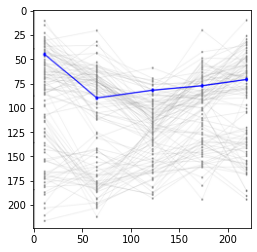

In [13]:
# log version
func_dl.showImg(combined_img[17766])

In [15]:
np.unique(combined_label)

array([0, 1, 2])

## Find the unique numbers from the train labels

In [16]:
classes = np.unique(combined_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")

Total number of outputs :  3
Output classes :  [0 1 2]
4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


In [17]:
#np.where(train_label==0)

2
[[1.         1.         1.        ]
 [0.6862745  0.6862745  0.6862745 ]
 [0.98039216 0.98039216 0.98039216]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]]


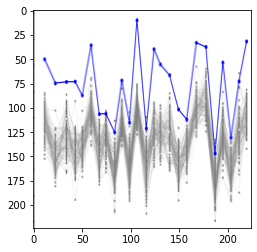

In [18]:
item = random.randint(0,len(combined_label))
#item = 110 
print(combined_label[item])
func_dl.showImg(combined_img[item])
print(combined_img[item][100][0:10])

## Train the deep nerual model by Hold-out validation
- Ref: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
### Split dataset into training(80%) and testing(20%) dataset

In [43]:
project_name

'rare_entire_cnv'

In [21]:
## split image arrays into trainining, validation and testing set
if project_name == 'rare_entire_cnv' or project_name == 'rare_entire_del' or project_name == 'rare_entire_dup':
    train_img, test_img, train_label_one_hot, test_label_one_hot, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img,
                                                                                                        combined_label_one_hot,
                                                                                                        combined_cnv_info_df,
                                                                                                        test_size=0.2,
                                                                                                        shuffle=True,
                                                                                                        random_state=seed)

    train_img, val_img, train_label_one_hot, val_label_one_hot, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                      train_label_one_hot,
                                                                                                      train_cnv_info_df,
                                                                                                      test_size=0.25,
                                                                                                      shuffle=True,
                                                                                                      random_state=seed) # 0.25*0.8=0.2

combined_img.shape, train_img.shape, val_img.shape, test_img.shape
combined_label_one_hot.shape, train_label_one_hot.shape, val_label_one_hot.shape, test_label_one_hot.shape

((22008, 3), (13204, 3), (4402, 3), (4402, 3))

In [22]:
## optional step: output the training+validation data and test data for comparsion with CN-Learn and DECoNT

# # train data
# train_val_cnv_info_df = train_cnv_info_df.append(val_cnv_info_df,  ignore_index=True)
# train_val_cnv_info_df.drop(train_val_cnv_info_df.columns[0], axis=1, inplace=True)
# train_val_cnv_info_df.shape

# comparison_path = '/home/rt2776/cnv_espresso/comparison_w_cnLearn/'
# train_val_cnv_info_df.to_csv(comparison_path+'CNVEspresso_training_validation_data.txt', index=None, sep='\t')

# # test data
# test_cnv_info_df.drop(test_cnv_info_df.columns[0], axis=1, inplace=True)
# test_cnv_info_df.shape
# comparison_path = '/home/rt2776/cnv_espresso/comparison_w_cnLearn/'
# test_cnv_info_df.to_csv(comparison_path+'CNVEspresso_test_data.txt', index=None, sep='\t')

Label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [0.9882353  0.9882353  0.9882353 ]
 [0.9882353  0.9882353  0.9882353 ]
 [0.8        0.8        0.8       ]
 [0.4745098  0.4745098  0.4745098 ]
 [0.7411765  0.7411765  0.7411765 ]
 [0.9490196  0.9490196  0.9490196 ]
 [0.96862745 0.96862745 0.96862745]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]]
One hot Label: [1. 0. 0.]


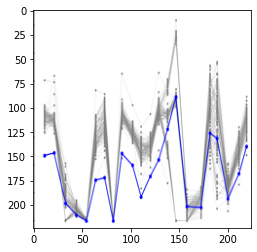

In [23]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
print("Label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
func_dl.showImg(train_img[i]),train_label_one_hot[i]#,train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]
print(train_img[i][100][80:100])
print("One hot Label:",train_label_one_hot[i])

In [24]:
test_img.shape, test_label_one_hot.shape, test_cnv_info_df.shape

((4402, 224, 224, 3), (4402, 3), (4402, 23))

In [25]:
np.min(test_cnv_info_df['NUM_TARGETS']), np.max(test_cnv_info_df['NUM_TARGETS'])

(1, 513)

In [26]:
test_cnv_info_df[test_cnv_info_df['NUM_TARGETS']<4]

,Unnamed: 0,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,...,MAP,NUM_TARGETS,SIZE_LABEL,LABEL_VAL,ref,batch,Num_Carriers(inGivenCohort),Num_Targets_Wins,image_path,img_path
8119,8119,6,27400370,27456921,DUP,SP0029239,1.0,1.00,1.0,3,...,1.00,3,F)50KB-75KB,1,hg38,spark3,1,6,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
17649,17649,17,41836342,41837588,DUP,SP0040215,0.0,0.00,1.0,1,...,1.00,3,B)1KB-5KB,0,hg38,spark3,56,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
6045,6045,4,129093069,129106647,DEL,SP0125643,1.0,0.00,0.0,1,...,1.00,3,D)10KB-25KB,0,hg38,spark9,0,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
6958,6958,13,75537381,75537805,DUP,SP0013148,0.0,1.00,1.0,2,...,1.00,3,A)<1KB,1,hg38,spark1,136,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
13987,13987,5,178120177,178122001,DUP,SP0107699,0.0,1.00,1.0,2,...,1.00,3,B)1KB-5KB,1,hg38,spark9,1,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,9370,19,57813293,57819946,DUP,SP0044377,0.0,0.81,1.0,2,...,0.97,3,C)5KB-10KB,1,hg38,spark4,110,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
1812,1812,9,113049361,113056688,DEL,SP0046136,1.0,1.00,1.0,3,...,1.00,3,C)5KB-10KB,1,hg38,spark4,34,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
11197,11197,6,32641309,32642764,DUP,SP0066994,0.0,0.00,1.0,1,...,0.94,3,B)1KB-5KB,1,hg38,spark6,2,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
6051,6051,3,48576248,48576557,DEL,SP0126058,0.0,0.00,1.0,1,...,1.00,3,A)<1KB,0,hg38,spark9,0,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...


## Visulize training and testing dataset
- In order to check the performance in different size categories (number of windows/targets), we need to check the distribution of CNVs in training and testing set.

In [70]:
sns.set(font="Arial black")

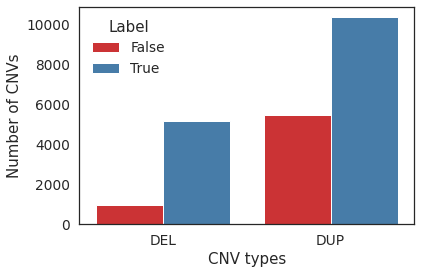

In [113]:
output_figure_file = figure_path+'figure3a_label_counts.pdf'

sns.set_theme(style="white", font_scale=1.25)

fig = sns.countplot(x="TYPE", 
                    data=combined_cnv_info_df.sort_values(by='TYPE'), 
                    hue="LABEL_VAL",
                    palette="Set1")

plt.legend(title='Label', loc='upper left', labels=['False','True'], frameon=False)
fig.set(xlabel="CNV types", ylabel="Number of CNVs")

plt.savefig(output_figure_file,bbox_inches = 'tight')

In [87]:
combined_cnv_info_df

,Unnamed: 0,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,...,MAP,NUM_TARGETS,SIZE_LABEL,LABEL_VAL,ref,batch,Num_Carriers(inGivenCohort),Num_Targets_Wins,image_path,img_path
0,0,6,144447210,144462866,DEL,SP0000267,1.0,1.00,1.0,3,...,1.00,9,D)10KB-25KB,1,hg38,spark1,1,9,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
1,1,19,22653399,22756778,DEL,SP0000267,0.0,0.00,1.0,1,...,0.96,5,H)100KB-250KB,1,hg38,spark1,128,6,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
2,2,20,49539569,49550189,DEL,SP0000285,0.0,1.00,1.0,2,...,1.00,4,D)10KB-25KB,1,hg38,spark1,15,4,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
3,3,19,56189826,56193052,DEL,SP0000523,1.0,0.69,1.0,3,...,0.95,4,B)1KB-5KB,1,hg38,spark1,1,4,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
4,4,10,27398293,27414250,DEL,SP0000551,1.0,1.00,0.0,2,...,1.00,4,D)10KB-25KB,1,hg38,spark1,107,5,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22003,22003,9,21166042,21239935,DUP,SP0151577,0.0,1.00,0.0,1,...,0.95,7,F)50KB-75KB,0,hg38,spark10,26,7,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
22004,22004,15,51782720,51863010,DUP,SP0153750,0.0,1.00,0.0,1,...,1.00,5,G)75KB-100KB,0,hg38,spark10,1,5,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
22005,22005,3,195739846,195749064,DUP,SP0154149,0.0,0.00,1.0,1,...,0.99,3,C)5KB-10KB,0,hg38,spark10,80,3,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...
22006,22006,19,17282056,17284266,DUP,SP0154150,0.0,0.00,1.0,1,...,1.00,5,B)1KB-5KB,0,hg38,spark10,0,5,/home/rt2776/cnv_espresso/images_rare_3classes...,/home/rt2776/cnv_espresso/project0_train_model...


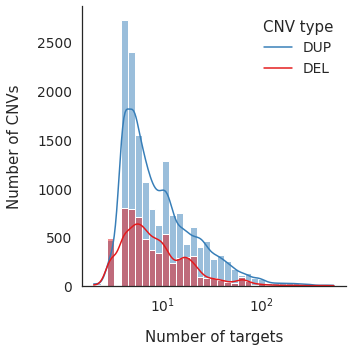

In [115]:
## all the data
output_figure_file = figure_path+'figure3b_num_targets_wins.pdf'
sns.set_theme(style="white", font_scale=1.25)
fig = sns.displot(data=combined_cnv_info_df.sort_values(by='TYPE'),
                  bins=35,
                  x="Num_Targets_Wins", hue="TYPE", log_scale=True, kde=True,
                  palette="Set1",legend=False)

#plt.xticks([1,2,3,4,5,6,7,8,9,10, 100]) #x轴的刻度值
fig.set_axis_labels("Number of targets", "Number of CNVs", labelpad=15)
plt.legend(title='CNV type', loc='upper right',
           labels=['DUP','DEL'],frameon=False)

fig.savefig(output_figure_file)
## note: the bar is illustrated by the single type, not cumulated. For example, #win=4, del: 802 and dup:2729.

In [ ]:
## training data
output_figure_file = output_figure_path+'train_entire_cnv_num_targets_wins.png'

fig = sns.displot(data=train_cnv_info_df.sort_values(by='TYPE')
                  , x="Num_Targets_Wins", hue="TYPE", log_scale=True, kde=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10, 100]) #x轴的刻度值
fig.savefig(output_figure_file, facecolor='w', edgecolor='w', bbox_inches = 'tight',dpi=150)
## note: the bar is illustrated by the single type, not cumulated. For example, #win=4, del: 802 and dup:2729.

In [ ]:
## validation data
output_figure_file = output_figure_path+'validation_entire_cnv_num_targets_wins.png'

fig = sns.displot(data=val_cnv_info_df.sort_values(by='TYPE')
                  , x="Num_Targets_Wins", hue="TYPE", log_scale=True, kde=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10, 100]) #x轴的刻度值
fig.savefig(output_figure_file, facecolor='w', edgecolor='w', bbox_inches = 'tight',dpi=150)
## note: the bar is illustrated by the single type, not cumulated. For example, #win=4, del: 802 and dup:2729.

In [ ]:
## testing data
output_figure_file = output_figure_path+'test_entire_cnv_num_targets_wins.png'

fig = sns.displot(data=test_cnv_info_df.sort_values(by='TYPE')
                  , x="Num_Targets_Wins", hue="TYPE", log_scale=True, kde=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10, 100]) #x轴的刻度值
fig.savefig(output_figure_file, facecolor='w', edgecolor='w', bbox_inches = 'tight',dpi=150)
## note: the bar is illustrated by the single type, not cumulated. For example, #win=4, del: 802 and dup:2729.

## Model comparision and selection

In [29]:
## original version
# model_dir = '/home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/data_backup/model_h5/'

## [09/20/2021] log version
print(model_dir)
# model_dir = '/home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY/model_h5/'

/home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//model_h5/


### Sequential CNN model

In [41]:
model_name='CNN_model'
print("Model name: %s"%model_name)
model = func_dl.cnn_model(model_name, nClasses, input_shape)
model.summary()
print("Number of layers:", len(model.layers))

Model name: CNN_model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (No

In [52]:
print("Training by a common CNN model ...")
time_start = timeit.default_timer()

batch_size = 32
epochs = 20
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label_one_hot,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label_one_hot), 
                    callbacks=[es, mc]) ## easy to exhaust the memory by using "validation_split = 0.2"

time_stop = timeit.default_timer()
print('Time (minutes): ', (time_stop - time_start)/60) 
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label_one_hot)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nprecision:",precision, "\nrecall:",recall, "\nf1_score:",f1_score)

Training by a common CNN model ...
Epoch 1/20
413/413 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.6606 - f1_m: 0.5762 - precision_m: 0.6512 - recall_m: 0.5486
Epoch 00001: val_accuracy improved from -inf to 0.71059, saving model to /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//model_h5/rare_entire_cnv_CNN_model_3classes.h5
413/413 [==============================] - 65s 158ms/step - loss: 0.7408 - accuracy: 0.6606 - f1_m: 0.5762 - precision_m: 0.6512 - recall_m: 0.5486 - val_loss: 0.5724 - val_accuracy: 0.7106 - val_f1_m: 0.7082 - val_precision_m: 0.7167 - val_recall_m: 0.7001
Epoch 2/20
413/413 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8386 - f1_m: 0.8369 - precision_m: 0.8464 - recall_m: 0.8280
Epoch 00002: val_accuracy improved from 0.71059 to 0.81758, saving model to /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//model_h5/rare_entire_cnv_CNN_model_3classes.h5
413/413 [=====================

In [54]:
print("Model_name:",model_name)
print('Time (minutes): ', (time_stop - time_start)/60) 
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label_one_hot)
print("loss:",loss, "\naccuracy:",accuracy, "\nprecision:",precision, "\nrecall:",recall, "\nf1_score:",f1_score)

Model_name: CNN_model
Time (minutes):  12.018917331766959
138/138 [==============================] - 5s 40ms/step - loss: 0.2860 - accuracy: 0.8864 - f1_m: 0.8857 - precision_m: 0.8882 - recall_m: 0.8834
loss: 0.28598445653915405 
accuracy: 0.8864152431488037 
precision: 0.888222873210907 
recall: 0.8833534717559814 
f1_score: 0.8857425451278687


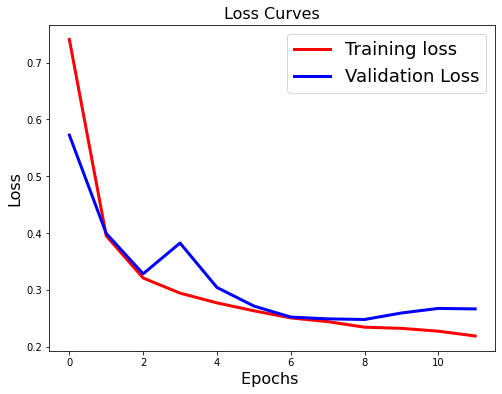

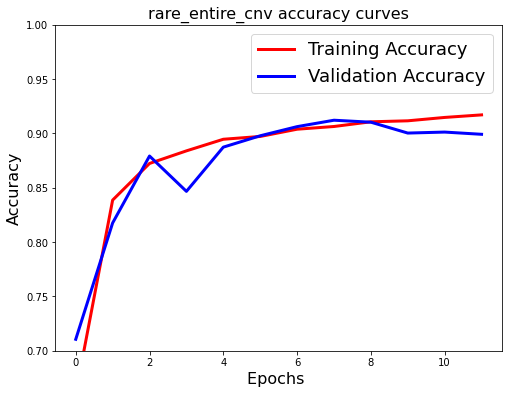

In [55]:
func_dl.draw_loss_accuracy_curves(history, project_name)

### MobileNet v1

In [58]:
model_name='MobileNet_v1'
print("Model name: %s"%model_name)
#model = func_dl.cnn_model(model_name, nClasses, input_shape)
model = func_dl.transfer_learning_model(model_name, nClasses, learning_rate = 1e-4, trainable=True)
model.summary()

Model name: MobileNet_v1
Model name: MobileNet_v1, nClasses: 3, Learning rate:0.000100, Trainable: True
Number of base model layers: 87
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [59]:
## len(model.layers) - 1 +  Number of base model layers 
print("Number of layers for MobileNet v1:", len(model.layers)-1+87)

Number of layers for MobileNet v1: 90


In [61]:
time_start = timeit.default_timer()

print("Training by %s model ..."%model_name)
batch_size = 32
epochs = 20

model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label_one_hot,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label_one_hot), 
                    callbacks=[es, mc]) ## easy to exhaust the memory by using "validation_split = 0.2"

time_stop = timeit.default_timer()
print('Time (minutes): ', (time_stop - time_start)/60) 
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label_one_hot)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nprecision:",precision, "\nrecall:",recall, "\nf1_score:",f1_score)

Training by MobileNet_v1 model ...
Epoch 1/20
413/413 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.8995 - f1_m: 0.8982 - precision_m: 0.9020 - recall_m: 0.8947
Epoch 00001: val_accuracy improved from -inf to 0.92322, saving model to /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//model_h5/rare_entire_cnv_MobileNet_v1_3classes.h5
413/413 [==============================] - 75s 181ms/step - loss: 0.2629 - accuracy: 0.8995 - f1_m: 0.8982 - precision_m: 0.9020 - recall_m: 0.8947 - val_loss: 0.2108 - val_accuracy: 0.9232 - val_f1_m: 0.9235 - val_precision_m: 0.9258 - val_recall_m: 0.9212
Epoch 2/20
413/413 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9476 - f1_m: 0.9477 - precision_m: 0.9488 - recall_m: 0.9467
Epoch 00002: val_accuracy improved from 0.92322 to 0.92935, saving model to /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//model_h5/rare_entire_cnv_MobileNet_v1_3classes.h5
413/413 [===============

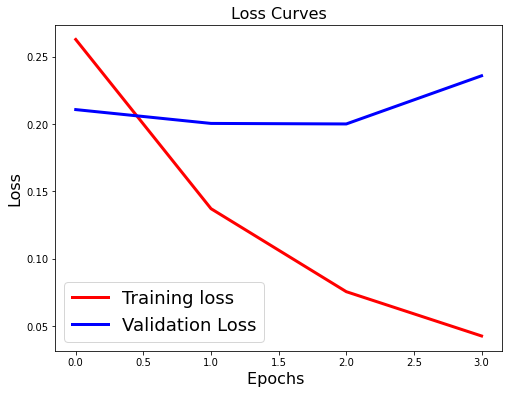

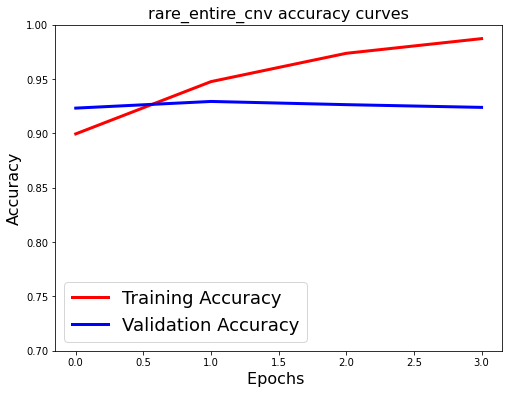

In [62]:
func_dl.draw_loss_accuracy_curves(history, project_name)

In [64]:
print("Model_name:",model_name)
print('Time (minutes): ', (time_stop - time_start)/60) 
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label_one_hot)
print("loss:",loss, "\naccuracy:",accuracy, "\nprecision:",precision, "\nrecall:",recall, "\nf1_score:",f1_score)

Model_name: MobileNet_v1
Time (minutes):  5.138811826116095
138/138 [==============================] - 6s 42ms/step - loss: 0.2733 - accuracy: 0.9116 - f1_m: 0.9116 - precision_m: 0.9120 - recall_m: 0.9112
loss: 0.2732744514942169 
accuracy: 0.9116310477256775 
precision: 0.9119746088981628 
recall: 0.911156415939331 
f1_score: 0.9115589261054993


#### Question: 
which model will be used for evaluating the test data?

Answer: the model will be chosen as the last training one. 
    but the model has been saved when it has the best performance.

In [ ]:
model.evaluate(val_img, val_label)
# this result is exactly as the last training result (epoch 5)

In [ ]:
model_saved_file = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_3classes.h5'

custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}
model_saved = keras.models.load_model(model_saved_file, custom_objects=custom_objects)
model_saved.evaluate(val_img, val_label)

In [ ]:
model_saved.evaluate(test_img, test_label)

### ResNet50

In [65]:
model_name='ResNet50'
print("Model name: %s"%model_name)
model = func_dl.transfer_learning_model(model_name, nClasses, learning_rate = 1e-4, trainable=True)
model.summary()

Model name: ResNet50
Number of base model layers: 175
Model name: ResNet50, nClasses: 3, Learning rate:0.000100, Trainable: True
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


In [40]:
## len(model.layers) - 1 +  Number of base model layers 
print("Number of layers for ResNet50: ", 175 -1 +4)

Number of layers for ResNet50:  178


In [67]:
time_start = timeit.default_timer()

print("Training by %s model ..."%model_name)
batch_size = 32
epochs = 20

model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label_one_hot,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label_one_hot), 
                    callbacks=[es, mc]) ## easy to exhaust the memory by using "validation_split = 0.2"

time_stop = timeit.default_timer()


Training by ResNet50 model ...
Epoch 1/20
413/413 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9034 - f1_m: 0.9026 - precision_m: 0.9069 - recall_m: 0.8984
Epoch 00001: val_accuracy improved from -inf to 0.91095, saving model to /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//model_h5/rare_entire_cnv_ResNet50_3classes.h5
413/413 [==============================] - 131s 318ms/step - loss: 0.2562 - accuracy: 0.9034 - f1_m: 0.9026 - precision_m: 0.9069 - recall_m: 0.8984 - val_loss: 0.2342 - val_accuracy: 0.9109 - val_f1_m: 0.9104 - val_precision_m: 0.9124 - val_recall_m: 0.9085
Epoch 2/20
413/413 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9355 - f1_m: 0.9349 - precision_m: 0.9363 - recall_m: 0.9336
Epoch 00002: val_accuracy improved from 0.91095 to 0.92095, saving model to /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//model_h5/rare_entire_cnv_ResNet50_3classes.h5
413/413 [==========================

In [69]:
print('Time (minutes): ', (time_stop - time_start)/60) 
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label_one_hot)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Time (minutes):  13.326055867985511
138/138 [==============================] - 14s 98ms/step - loss: 0.2987 - accuracy: 0.9139 - f1_m: 0.9131 - precision_m: 0.9136 - recall_m: 0.9126
Model_name: ResNet50
loss: 0.29867005348205566 
accuracy: 0.913902759552002 
f1_score: 0.9130828976631165 
precision: 0.9136173129081726 
recall: 0.9125654101371765


In [ ]:
func_dl.draw_loss_accuracy_curves(history, project_name)

In [ ]:
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

In [ ]:
func_dl.confusion_matrix(model, test_img, test_label, nClasses)

## MobileNet v1. Transfer learning and fine-tuning

### MobileNet v1. use its architecture and set all the weights trainable

In [ ]:
model_name='MobileNet_v1'
print("Model name: %s"%model_name)
model = func_dl.cnn_model(model_name, nClasses,input_shape)
model.summary()
func.showDateTime()

In [ ]:
model_name='MobileNet_v1_classic_tsf'
model = func_dl.transfer_learning_model("MobileNet_v1",nClasses,learning_rate= 1e-4,trainable=True)
model.summary()

In [ ]:
print("Training by MobileNet_v1 model ...")
batch_size = 100
epochs = 10
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

In [ ]:
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
func_dl.draw_loss_accuracy_curves(history, project_name)

In [ ]:
func_dl.confusion_matrix(model, test_img, test_label, nClasses)

In [ ]:
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

In [ ]:
# output model metrics
output_file = model_dir + project_name + "_" + model_name + "_model_metrics0920.txt"
func_dl.output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)
func.showDateTime()

### MobileNet v1. transfer learning and fine tuning
- Firstly, we keep all the weights of base model frozen to train the fc layers.

In [ ]:
model_name='MobileNet_v1_fine-tuning'
base_model = tf.keras.applications.MobileNet(
weights='imagenet',  # Load weights pre-trained model.
input_shape=(224, 224, 3),    #input_shape=(224, 224, 3),
include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3)) #keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nClasses,activation='softmax')(x)      
model = keras.Model(inputs, outputs)
model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [ ]:
print("Training by MobileNet_v1 model ...")
batch_size = 32
epochs = 20
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

In [ ]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

- Secondly, Once your model has converged on our train data, we unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

In [ ]:
print("Fine tuning by MobileNet_v1 model ...")
batch_size = 32
epochs = 20
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

base_model.trainable=True
model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy', metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

In [ ]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

In [ ]:
!cp /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5 \
    /home/rt2776/cnv_espresso/model/MobileNet_v1_fine_tuning_20210524.h5

### Reload the model and evaluate the model's performance
It is strange that the performance improves alots after reloading the model, 

In [ ]:
## Load model

#model_file = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_3classes_fold1_0221.h5'
#model_file = '/home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5'
model_file = model_dir + 'rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5'
print("Model:%s"%model_file)

Tensorflow version 2.2.0

--- Confusion matrix for test data ---

3 classes label: 0-True del; 1-True dip; 2-True dup
Figure has been output plot to: /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/figure4b_confusion_matrix.pdf


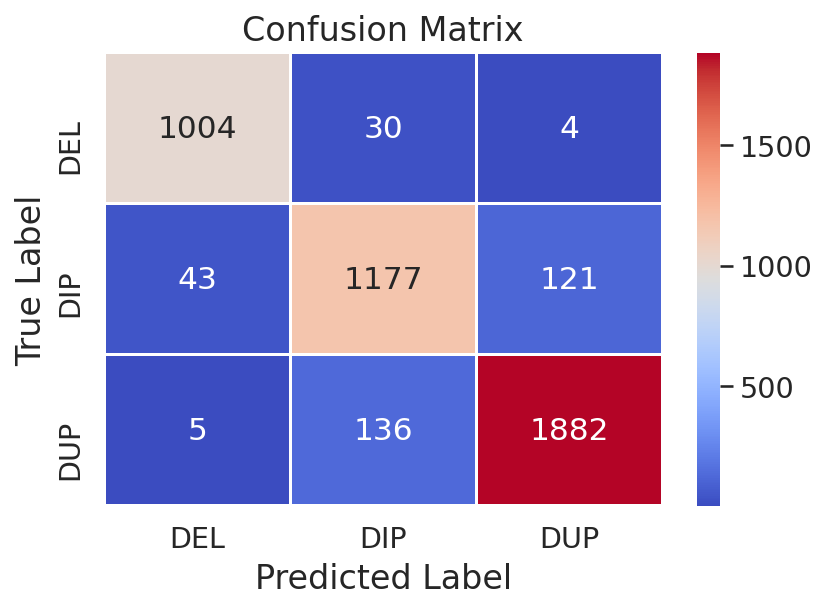


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1038
           1       0.88      0.88      0.88      1341
           2       0.94      0.93      0.93      2023

    accuracy                           0.92      4402
   macro avg       0.92      0.93      0.92      4402
weighted avg       0.92      0.92      0.92      4402



In [96]:
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}
output_img_file = figure_path+'figure4b_confusion_matrix.pdf'

model = keras.models.load_model(model_file, custom_objects=custom_objects)
func_dl.confusion_matrix(model, test_img, test_label_one_hot, nClasses=3, output_img_file=output_img_file)

In [48]:
# output model metrics
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label_one_hot)
output_file = figure_path + "figure4b_confusion_matrix_model_metrics.txt"
func_dl.output_model_metrics(project_name, loss, accuracy, f1_score, precision, recall, output_file)
func.showDateTime()

138/138 [==============================] - 5s 35ms/step - loss: 0.2586 - accuracy: 0.9230 - f1_m: 0.9229 - precision_m: 0.9231 - recall_m: 0.9227
[INFO]: File outputs to /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/figure4b_confusion_matrix_model_metrics.txt
[2021.09.21-11:07:26]


ROC curve output plot to: /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/figure4c_ROC_curve.pdf


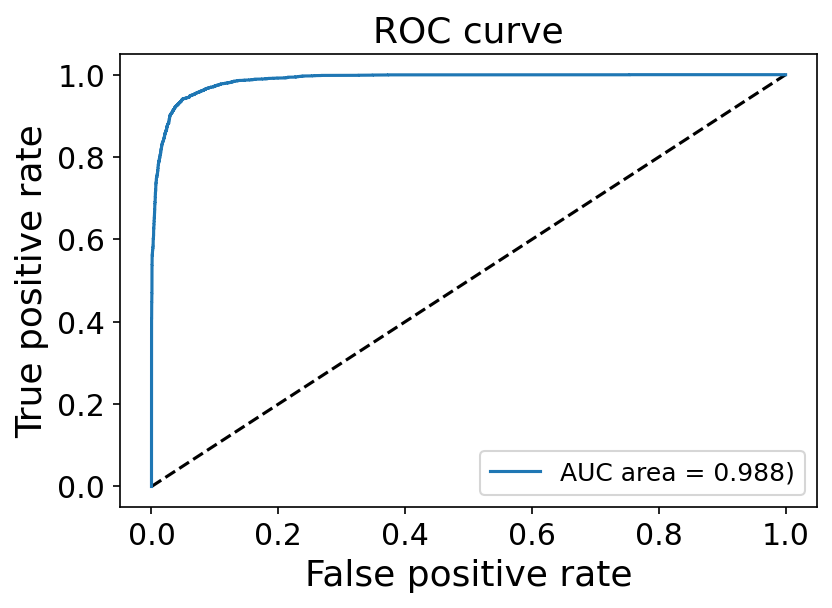

Zoomed ROC curve output plot to: /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/figure4c_ROC_curve_zoom.pdf


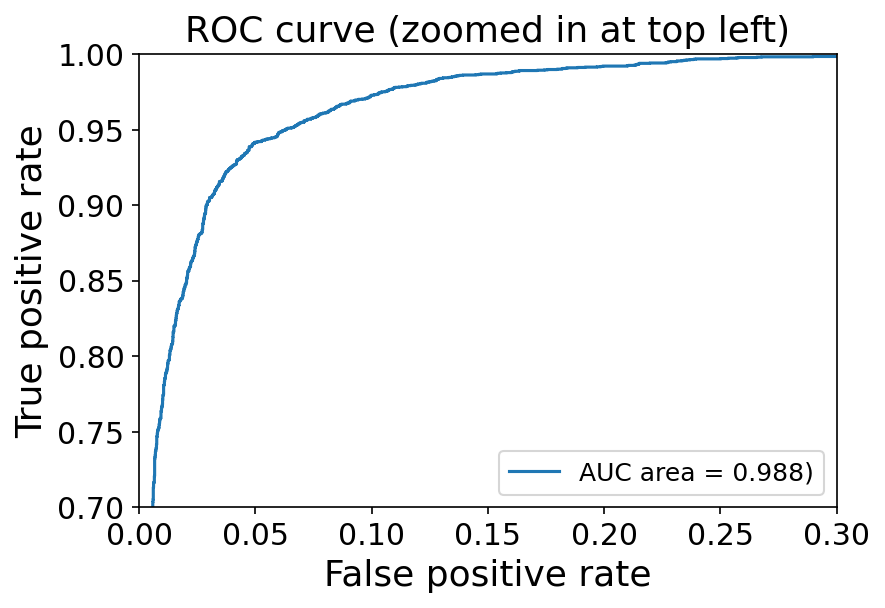

In [49]:
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label_one_hot)

output_img_file = figure_path+'figure4c_ROC_curve.pdf'
func_dl.draw_single_roc_curve(tpr, fpr, auc, output_img_file=output_img_file)

## K-fold cross validation

In [ ]:
## Original
# model_dir = '/home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/data_backup/model_h5/'

## Log transformated version
model_dir = '/home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY/data_backup/model_h5/'

model_name='MobileNet_v1'

seed = 6666
num_folds = 5
# Define the K-fold Cross Validator
#kfold = KFold(n_splits=num_folds, shuffle=True)
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

In [ ]:
VALIDATION_ACCURACY, VALIDATION_LOSS = [], []
tpr_list, tpr_interp_list, fpr_list, auc_list = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)

nClasses = 3

# K-fold Cross Validation model evaluation

train_val_img, test_img, train_val_label, test_label = train_test_split(combined_img,
                                                                      combined_label,
                                                                      test_size=0.2,
                                                                      shuffle=True,
                                                                      random_state=seed)

In [ ]:
test_label_one_hot = to_categorical(test_label)

In [ ]:
fold_num = 0
for train_index, val_index in kfold.split(train_val_img, train_val_label):
    print('------------------------------------------------------------------------')
    func.showDateTime()
    print('Training for fold %d ...'%fold_num)
    print("num_index",len(train_index), len(val_index))
   
    train_img  = train_val_img[train_index]
    train_label_one_hot = to_categorical(np.array(train_val_label)[train_index])
    
    val_img  = train_val_img[val_index]
    val_label_one_hot = to_categorical(np.array(train_val_label)[val_index])
    
    print("Combined:", combined_img.shape, combined_label_one_hot.shape)
    print("Train:", train_img.shape, train_label_one_hot.shape)
    print("Validation:", val_img.shape, val_label_one_hot.shape)
    print("Test:", test_img.shape, test_label_one_hot.shape)
    
    # CREATE and COMPILE NEW MODEL
    model_name='MobileNet_v1'
    print("Model name: %s"%model_name)
    model = func_dl.cnn_model(model_name, nClasses, input_shape)
    
    model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses)+ "classes_fold" +str(fold_num)+"_0524.h5"
    
    # CREATE CALLBACKS
    batch_size = 32
    epochs = 50
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    checkpoint = ModelCheckpoint(model_file,
                         monitor='val_accuracy',
                         mode='max', 
                         verbose=1, 
                         save_best_only=True)
    callbacks_list = [checkpoint]
    
    # FIT THE MODEL
    print("Fit the model ...")
    history = model.fit(train_img, train_label_one_hot,
                        batch_size=batch_size, 
                        epochs=epochs, verbose=1, 
                        validation_data=(val_img, val_label_one_hot), 
                        callbacks=[es, checkpoint])
    ## easy to exhaust the memory by using "validation_split = 0.2"

    # LOAD BEST MODEL to evaluate the performance of the model
    print("Load weights...")
    model.load_weights(model_file)

    print("Evaluate ...")
    results = model.evaluate(test_img, test_label_one_hot)
    results = dict(zip(model.metrics_names,results))
    print(results)
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    fpr_roc, tpr_roc, thresholds_roc, auc_roc = func_dl.pred_roc_data(model, test_img, test_label_one_hot)    

    interp_tpr = np.interp(mean_fpr, fpr_roc, tpr_roc)
    interp_tpr[0] = 0.0
    
    tpr_list.append(tpr_roc)
    tpr_interp_list.append(interp_tpr)
    fpr_list.append(fpr_roc)
    auc_list.append(auc_roc)
    
    tf.keras.backend.clear_session()
    fold_num += 1

In [92]:
output_image_file = figure_path+ "/" +"figure4a_kfold_roc_curve.pdf"
func_dl.draw_kfold_roc_curve(tpr_list, tpr_interp_list, fpr_list, auc_list, output_image_file)

#copy pdf to figure folder
#! cp /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_roc_curve.pdf /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/figures/figure4a_ROC_curve.pdf

NameError: name 'tpr_interp_list' is not defined

## Result analysis
### Check the predict performance in different target numbers categories

#### Import trained model

In [50]:
if test_label.shape[1] == 3:
    test_label_one_hot = test_label

In [51]:
# model_path = '/home/rt2776/cnv_espresso/model/MobileNet_v1_fine_tuning_3classes.h5'
# model_path = '/home/rt2776/cnv_espresso/model/MobileNet_v1_fine_tuning_20210524.h5'
model_path = model_dir + 'rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5'

custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}
model = keras.models.load_model(model_path, custom_objects=custom_objects)

loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label_one_hot)

138/138 [==============================] - 5s 35ms/step - loss: 0.2586 - accuracy: 0.9230 - f1_m: 0.9229 - precision_m: 0.9231 - recall_m: 0.9227


#### Briefly check the data

- Sort zip(CNV info, img and label) by the number of windows

In [ ]:
zip(test_cnv_info_df, test_img, test_label)

In [ ]:
test_cnv_info_df.index

In [ ]:
test_img[test_cnv_info_df.index]

In [52]:
min_win = 2
max_win = 4
selected_test_df, selected_test_img, selected_test_label = func_dl.fetch_df_by_wins(test_cnv_info_df, test_img, test_label_one_hot, min_win, max_win, sort = True)

There is/are 913 CNVs with number of targets/windows between 2 and 4.


Unnamed: 0                                                                 11803
CHR                                                                           19
PRED_START                                                              57814532
PRED_END                                                                57819946
TYPE                                                                         DUP
SAMPLE                                                                 SP0076107
CANOES_RT                                                                      1
CLAMMS_RT                                                                      1
XHMM_RT                                                                        1
NUM_OVERLAPS_RT                                                                3
RD_PROP_RT                                                                  1.62
GC                                                                           0.5
PRED_SIZE                   

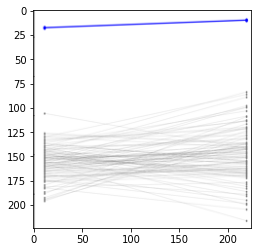

In [53]:
print(selected_test_df.iloc[0,:])
print(selected_test_label[0])
func_dl.showImg(selected_test_img[0])

In [54]:
# test_label_one_hot = to_categorical(test_label)
# test_label_one_hot = test_label
test_img.shape, test_label_one_hot.shape, test_label_one_hot.shape, test_cnv_info_df.shape

((4402, 224, 224, 3), (4402, 3), (4402, 3), (4402, 23))

In [55]:
# are they same?
(to_categorical(test_label)==test_label_one_hot).all()

<ipython-input-55-d5f2223430b4>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (to_categorical(test_label)==test_label_one_hot).all()


AttributeError: 'bool' object has no attribute 'all'

#### Get the ROC curve for different number of windows

In [56]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

#please note that here is the number of WINDOWS not Target.
for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label_one_hot,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)

Processing num_windows: 2-2 ...
There is/are 11 CNVs with number of targets/windows between 2 and 2.
Processing num_windows: 3-3 ...
There is/are 202 CNVs with number of targets/windows between 3 and 3.
Processing num_windows: 4-4 ...
There is/are 700 CNVs with number of targets/windows between 4 and 4.
Processing num_windows: 5-5 ...
There is/are 667 CNVs with number of targets/windows between 5 and 5.
Processing num_windows: 6-6 ...
There is/are 457 CNVs with number of targets/windows between 6 and 6.
Processing num_windows: 7-7 ...
There is/are 296 CNVs with number of targets/windows between 7 and 7.
Processing num_windows: 8-8 ...
There is/are 215 CNVs with number of targets/windows between 8 and 8.
Processing num_windows: 9-9 ...
There is/are 188 CNVs with number of targets/windows between 9 and 9.
Processing num_windows: 10-10 ...
There is/are 179 CNVs with number of targets/windows between 10 and 10.


In [57]:
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label_one_hot,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label_one_hot,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label_one_hot,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label_one_hot,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label_one_hot,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

Processing num_windows: 11-15 ...
There is/are 515 CNVs with number of targets/windows between 11 and 15.
Processing num_windows: 16-20 ...
There is/are 305 CNVs with number of targets/windows between 16 and 20.
Processing num_windows: 21-50 ...
There is/are 505 CNVs with number of targets/windows between 21 and 50.
Processing num_windows: 51-100 ...
There is/are 112 CNVs with number of targets/windows between 51 and 100.
Processing num_windows: 101-600 ...
There is/are 50 CNVs with number of targets/windows between 101 and 600.


ROC curve output plot to: /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/figure5_roc_w_different_tgs.pdf


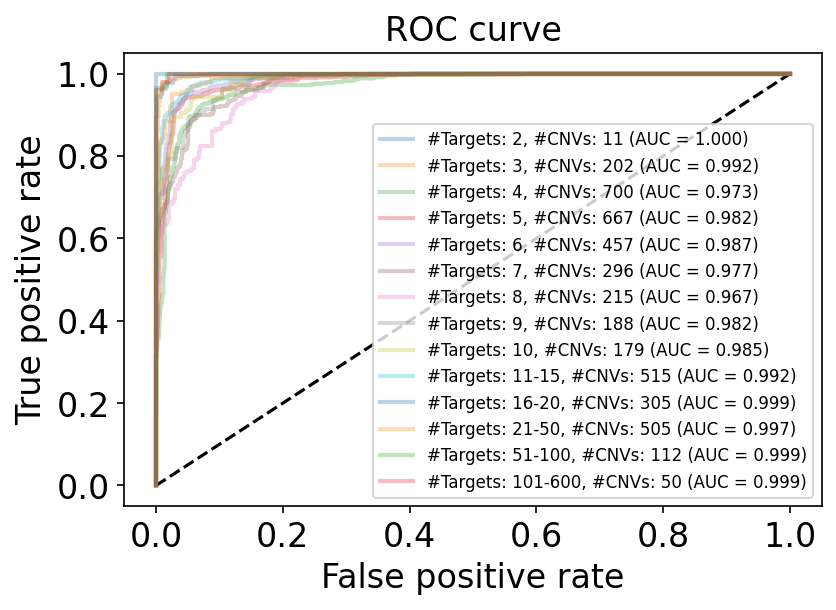

Zoomed ROC curve output plot to: /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/figure5_roc_w_different_tgs_zoom.pdf


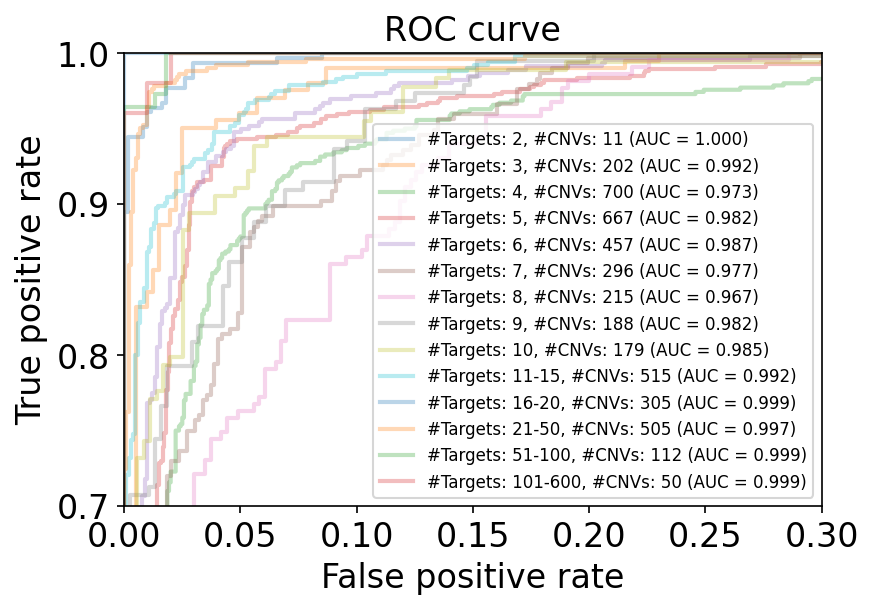

In [58]:
output_img_file = figure_path + 'figure5_roc_w_different_tgs.pdf'
func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, output_image_file=output_img_file)

#### Look deeper to analysis which and why some of CNVs/images were predicted in error
Especially for #target 5 to 10

In [67]:
# min_win = 1
# max_win = 4

# min_win = 5
# max_win = 10

min_win = 11
max_win = 600

selected_test_df, selected_test_img, selected_test_label = func_dl.fetch_df_by_wins(test_cnv_info_df, test_img, test_label_one_hot, min_win, max_win, sort=True)

There is/are 1487 CNVs with number of targets/windows between 11 and 600.


In [68]:
len(selected_test_img)

1487

In [69]:
output_img_path = figure_path
output_correct_img_file   = output_img_path+'Pred_monitor_correct_'+str(min_win).zfill(3)+'_'+ str(max_win).zfill(3) +'.pdf'
output_incorrect_img_file = output_img_path+'Pred_monitor_incorrect_'+str(min_win).zfill(3)+'_'+ str(max_win).zfill(3)+'.pdf'

with PdfPages(output_incorrect_img_file) as pdf_incorrect:    
    with PdfPages(output_correct_img_file) as pdf_correct:      
        for i in range(0,len(selected_test_img)):
            img_pred = model.predict(selected_test_img[i:i+1])

            cnv_info_df = selected_test_df.iloc[i]
            cnv_info = "%s %d:%d-%d %s\n"%(cnv_info_df['SAMPLE'],cnv_info_df['CHR'], \
                                      cnv_info_df['PRED_START'], cnv_info_df['PRED_END'],\
                                      cnv_info_df['TYPE'])

            cnv_info += "XHMM:%.1f, CANOES:%.1f, CLAMMS:%.1f #Caller:%d\n #targets:%d Size:%d #Carriers:%d #label_val:%d"%(
                        cnv_info_df['XHMM_RT'],\
                        cnv_info_df['CANOES_RT'],\
                        cnv_info_df['CLAMMS_RT'],\
                        cnv_info_df['NUM_OVERLAPS_RT'],\
                        cnv_info_df['NUM_TARGETS'],\
                        cnv_info_df['PRED_SIZE'],\
                        cnv_info_df['Num_Carriers(inGivenCohort)'],\
                        cnv_info_df['LABEL_VAL']
                        )
            
            print(i, cnv_info)
            if np.argmax(img_pred) == 0:
                pred_result = "DEL"
            elif np.argmax(img_pred) == 1:
                pred_result = "DIP_NotRare"
            elif np.argmax(img_pred) == 2:
                pred_result = "DUP"
            cnv_type = selected_test_df.iloc[i]['TYPE']

            if cnv_info_df['LABEL_VAL'] == 1:
                if pred_result == cnv_type:
                    pred_status = "Correct"
                    pred_color  = 'darkgreen'
                else:
                    pred_status = "Incorrect"
                    pred_color  = 'red'
            elif cnv_info_df['LABEL_VAL'] == 0:
                if pred_result != cnv_type:
                    pred_status = "Correct"
                    pred_color  = 'darkgreen'
                else:
                    pred_status = "Incorrect"
                    pred_color  = 'red'
            else:
                pdb.set_trace()
                    
            label = "True" if cnv_info_df['LABEL_VAL'] == 1 else "False"
            pred_condition = "Label:" + label + \
                             "\nType:" + cnv_type + \
                             "\nPred:" + pred_result
            prob_txt = "P_DEL:" + str(round(img_pred[0][0],2)) + "\n"+\
                       "P_DIP: "+ str(round(img_pred[0][1],2)) + "\n"+\
                       "P_DUP:" + str(round(img_pred[0][2],2)) + "\n"

            # draw to a monitor image
            plt.imshow(selected_test_img[i])
            plt.title(cnv_info,fontsize='xx-small', fontweight="normal")

            plt.figtext(0.8,.95,"#Wins: "+str(cnv_info_df['Num_Targets_Wins']),fontsize='small',color = "blue", fontweight="extra bold")
            plt.figtext(0.8,0.9,pred_status,fontsize='small',color = pred_color, fontweight="extra bold")
            plt.figtext(0.8,0.7,pred_condition,fontsize='x-small')
            plt.figtext(0.8,0.5,prob_txt,fontsize='x-small')
            
            print(pred_status,"\n")
            
            if pred_status == "Correct":
                pdf_correct.savefig()
#                 pass
            else:
                pdf_incorrect.savefig()         
            plt.close()

0 SP0107699 11:71527300-71799647 DEL
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:11 Size:272347 #Carriers:83 #label_val:1
Correct 

1 SP0047799 8:3493622-4994416 DEL
XHMM:1.0, CANOES:0.8, CLAMMS:0.4 #Caller:3
 #targets:11 Size:1500794 #Carriers:1 #label_val:1
Correct 

2 SP0124694 6:52750576-52797637 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:1.0 #Caller:2
 #targets:11 Size:47061 #Carriers:3 #label_val:1
Correct 

3 SP0128353 1:17267836-17283079 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:11 Size:15243 #Carriers:113 #label_val:1
Correct 

4 SP0043290 19:43197996-43353993 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:10 Size:155997 #Carriers:28 #label_val:1
Incorrect 

5 SP0009187 19:53447268-53492086 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:6 Size:44818 #Carriers:16 #label_val:1
Correct 

6 SP0047105 1:158717167-158849237 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:10 Size:132070 #Carriers:2 #label_val:1
Correct 

7 SP0024295 8:991110

59 SP0052405 19:29942238-30015592 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.4 #Caller:3
 #targets:11 Size:73354 #Carriers:17 #label_val:1
Correct 

60 SP0126763 19:53447268-53492086 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:1.0 #Caller:2
 #targets:6 Size:44818 #Carriers:99 #label_val:1
Correct 

61 SP0093748 12:7870840-7929871 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:11 Size:59031 #Carriers:98 #label_val:0
Incorrect 

62 SP0015279 7:149859421-149879677 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:8 Size:20256 #Carriers:12 #label_val:1
Correct 

63 SP0088712 1:196825476-196910478 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.3 #Caller:3
 #targets:11 Size:85002 #Carriers:137 #label_val:1
Correct 

64 SP0011247 9:136739524-136748483 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:11 Size:8959 #Carriers:4 #label_val:1
Correct 

65 SP0087235 16:55810516-55833055 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:11 Size:22539 #Carriers:122 #label_val:0
Correct 

66 SP0097679

Correct 

118 SP0036733 11:34624259-34658932 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:11 Size:34673 #Carriers:9 #label_val:1
Correct 

119 SP0086010 5:176887001-176891550 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:11 Size:4549 #Carriers:16 #label_val:1
Correct 

120 SP0103027 21:44600621-44647355 DEL
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:2
 #targets:11 Size:46734 #Carriers:82 #label_val:1
Incorrect 

121 SP0063977 19:51936220-51974360 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:8 Size:38140 #Carriers:1 #label_val:1
Correct 

122 SP0053468 1:17267836-17283079 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:11 Size:15243 #Carriers:113 #label_val:1
Correct 

123 SP0117914 1:17267836-17283079 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:11 Size:15243 #Carriers:113 #label_val:1
Correct 

124 SP0134089 6:118465404-118538006 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.7 #Caller:2
 #targets:11 Size:72602 #Carriers:12 #label_val:1
Correc

176 SP0087397 6:32517738-32589742 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:12 Size:72004 #Carriers:142 #label_val:1
Correct 

177 SP0014957 15:40736540-40754789 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:12 Size:18249 #Carriers:1 #label_val:1
Correct 

178 SP0007216 19:15673529-15697085 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:12 Size:23556 #Carriers:88 #label_val:1
Correct 

179 SP0064927 7:149850160-149879677 DUP
XHMM:1.0, CANOES:0.7, CLAMMS:0.7 #Caller:3
 #targets:9 Size:29517 #Carriers:12 #label_val:1
Correct 

180 SP0136734 12:9153124-9165367 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:12 Size:12243 #Carriers:56 #label_val:1
Correct 

181 SP0015285 10:100152130-100189627 DUP
XHMM:0.6, CANOES:1.0, CLAMMS:0.6 #Caller:3
 #targets:12 Size:37497 #Carriers:9 #label_val:1
Correct 

182 SP0041831 19:54636493-54666749 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:12 Size:30256 #Carriers:9 #label_val:1
Correct 

183 SP010

234 SP0127879 6:32517738-32589742 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:12 Size:72004 #Carriers:142 #label_val:1
Correct 

235 SP0034972 8:11543224-11564108 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:12 Size:20884 #Carriers:11 #label_val:1
Correct 

236 SP0005862 6:32517738-32589742 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:12 Size:72004 #Carriers:142 #label_val:0
Correct 

237 SP0112076 4:95091490-95154673 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:12 Size:63183 #Carriers:105 #label_val:1
Incorrect 

238 SP0075755 8:22118949-22125504 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:12 Size:6555 #Carriers:0 #label_val:0
Incorrect 

239 SP0112076 19:39085269-39110118 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:12 Size:24849 #Carriers:140 #label_val:1
Correct 

240 SP0020636 17:32446944-32480631 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:12 Size:33687 #Carriers:108 #label_val:1
Correct 

241 

293 SP0130840 17:34155977-34320386 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:13 Size:164409 #Carriers:2 #label_val:1
Correct 

294 SP0023849 11:71527300-71818235 DEL
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:13 Size:290935 #Carriers:83 #label_val:1
Incorrect 

295 SP0050799 6:151341704-151366892 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:3 Size:25188 #Carriers:2 #label_val:1
Correct 

296 SP0134684 6:13622361-13696896 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:13 Size:74535 #Carriers:134 #label_val:1
Correct 

297 SP0083096 22:42519713-42574055 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.3 #Caller:3
 #targets:13 Size:54342 #Carriers:69 #label_val:1
Correct 

298 SP0082302 22:42512909-42556588 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.1 #Caller:3
 #targets:13 Size:43679 #Carriers:69 #label_val:1
Correct 

299 SP0017597 17:34577526-34638232 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:12 Size:60706 #Carriers:2 #label_val:1
Correct 

300 S

Incorrect 

351 SP0021522 10:73376094-73400856 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:13 Size:24762 #Carriers:1 #label_val:1
Correct 

352 SP0073806 17:81260237-81314462 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:13 Size:54225 #Carriers:2 #label_val:1
Correct 

353 SP0061965 16:82148730-83217497 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:13 Size:1068767 #Carriers:2 #label_val:1
Correct 

354 SP0139290 13:112545698-112690455 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:14 Size:144757 #Carriers:5 #label_val:1
Correct 

355 SP0085213 19:3816673-3869017 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.7 #Caller:3
 #targets:14 Size:52344 #Carriers:4 #label_val:1
Correct 

356 SP0085041 17:2371261-2388049 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:14 Size:16788 #Carriers:1 #label_val:1
Correct 

357 SP0011071 22:42436955-42556588 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:14 Size:119633 #Carriers:104 #label_val:1
Correct

409 SP0073768 4:169561479-169602630 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:14 Size:41151 #Carriers:11 #label_val:1
Correct 

410 SP0093947 4:188002807-188147372 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:14 Size:144565 #Carriers:6 #label_val:1
Correct 

411 SP0082982 7:4832140-4925532 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:12 Size:93392 #Carriers:1 #label_val:1
Correct 

412 SP0081789 1:225204182-225273125 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:14 Size:68943 #Carriers:4 #label_val:1
Correct 

413 SP0036574 22:23574966-23632023 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:14 Size:57057 #Carriers:9 #label_val:1
Correct 

414 SP0105586 3:41398078-41754488 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:14 Size:356410 #Carriers:2 #label_val:1
Correct 

415 SP0002706 2:197728466-197786101 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:14 Size:57635 #Carriers:112 #label_val:1
Correct 

416 SP01

468 SP0120349 1:246330479-246621634 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:15 Size:291155 #Carriers:3 #label_val:1
Correct 

469 SP0032987 19:49181348-49211269 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:15 Size:29921 #Carriers:1 #label_val:1
Correct 

470 SP0058179 14:67321056-67376590 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:15 Size:55534 #Carriers:1 #label_val:1
Correct 

471 SP0101393 9:111661634-111718288 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.6 #Caller:3
 #targets:15 Size:56654 #Carriers:2 #label_val:1
Correct 

472 SP0110175 1:119380692-119514645 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.3 #Caller:3
 #targets:15 Size:133953 #Carriers:1 #label_val:1
Correct 

473 SP0046235 12:32600409-32679987 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:15 Size:79578 #Carriers:4 #label_val:1
Correct 

474 SP0150044 12:132844026-132887328 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.8 #Caller:3
 #targets:15 Size:43302 #Carriers:1 #label_val:1
Correct 

475 SP

526 SP0006290 1:225023614-225119294 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.8 #Caller:3
 #targets:16 Size:95680 #Carriers:2 #label_val:1
Correct 

527 SP0065092 17:42562411-42570183 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:16 Size:7772 #Carriers:1 #label_val:1
Correct 

528 SP0106137 4:143880410-144120588 DUP
XHMM:0.9, CANOES:0.9, CLAMMS:1.0 #Caller:3
 #targets:16 Size:240178 #Carriers:41 #label_val:1
Correct 

529 SP0029339 22:21958166-21975759 DUP
XHMM:0.9, CANOES:0.9, CLAMMS:1.0 #Caller:3
 #targets:16 Size:17593 #Carriers:101 #label_val:1
Correct 

530 SP0139843 1:196788744-196910478 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:15 Size:121734 #Carriers:138 #label_val:1
Correct 

531 SP0083961 16:74413578-74470073 DUP
XHMM:1.0, CANOES:0.3, CLAMMS:0.3 #Caller:3
 #targets:15 Size:56495 #Carriers:3 #label_val:1
Correct 

532 SP0077617 1:1482137-1516088 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:16 Size:33951 #Carriers:75 #label_val:1
Correct 

533 SP

584 SP0011204 12:7869862-7936037 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:17 Size:66175 #Carriers:98 #label_val:1
Correct 

585 SP0104656 12:7869862-7936037 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:17 Size:66175 #Carriers:98 #label_val:1
Correct 

586 SP0136734 3:100818524-100838464 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:17 Size:19940 #Carriers:26 #label_val:1
Correct 

587 SP0020636 18:9547788-9588853 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:17 Size:41065 #Carriers:74 #label_val:1
Correct 

588 SP0043290 19:42867932-42937076 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:17 Size:69144 #Carriers:66 #label_val:1
Correct 

589 SP0080084 21:46636951-46664374 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:13 Size:27423 #Carriers:5 #label_val:1
Correct 

590 SP0114422 1:112702998-112726680 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:16 Size:23682 #Carriers:5 #label_val:1
Correct 

591 SP005454

642 SP0030168 2:185801268-185815471 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:3 Size:14203 #Carriers:10 #label_val:1
Correct 

643 SP0134999 6:35512811-35597404 DUP
XHMM:1.0, CANOES:0.2, CLAMMS:0.2 #Caller:3
 #targets:10 Size:84593 #Carriers:2 #label_val:1
Correct 

644 SP0081766 19:42867932-42937076 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:17 Size:69144 #Carriers:66 #label_val:1
Correct 

645 SP0030526 12:7869862-7936037 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:17 Size:66175 #Carriers:98 #label_val:1
Correct 

646 SP0071480 17:3610559-3658175 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:17 Size:47616 #Carriers:31 #label_val:1
Correct 

647 SP0020875 19:15658173-15697085 DUP
XHMM:1.0, CANOES:0.6, CLAMMS:0.6 #Caller:3
 #targets:17 Size:38912 #Carriers:82 #label_val:1
Correct 

648 SP0062507 16:461403-520840 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:17 Size:59437 #Carriers:1 #label_val:1
Correct 

649 SP0067108 22:

Correct 

701 SP0037350 12:52469061-52493188 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:18 Size:24127 #Carriers:8 #label_val:0
Incorrect 

702 SP0116796 18:21473030-21522821 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:18 Size:49791 #Carriers:4 #label_val:1
Correct 

703 SP0073660 2:28894698-28946779 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.6 #Caller:2
 #targets:18 Size:52081 #Carriers:18 #label_val:1
Correct 

704 SP0089962 15:43635726-43710088 DUP
XHMM:0.8, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:18 Size:74362 #Carriers:60 #label_val:1
Correct 

705 SP0138777 14:29577237-29725674 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:18 Size:148437 #Carriers:14 #label_val:1
Correct 

706 SP0112586 13:49185963-49259523 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:18 Size:73560 #Carriers:1 #label_val:1
Correct 

707 SP0138673 1:151767162-151783022 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:18 Size:15860 #Carriers:1 #label_val:1
Correct

Correct 

759 SP0047928 15:41536944-41578276 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.2 #Caller:2
 #targets:19 Size:41332 #Carriers:105 #label_val:1
Correct 

760 SP0115411 10:46129882-46330084 DUP
XHMM:1.0, CANOES:0.2, CLAMMS:0.2 #Caller:3
 #targets:18 Size:200202 #Carriers:87 #label_val:1
Correct 

761 SP0091645 7:158646459-158683386 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:19 Size:36927 #Carriers:112 #label_val:1
Correct 

762 SP0094951 15:41536944-41578276 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:19 Size:41332 #Carriers:124 #label_val:1
Correct 

763 SP0050432 1:203128314-203181285 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:19 Size:52971 #Carriers:1 #label_val:1
Correct 

764 SP0041660 3:319776-390816 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:19 Size:71040 #Carriers:8 #label_val:1
Correct 

765 SP0112076 1:113819576-113859460 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:19 Size:39884 #Carriers:99 #label_val:1
Correc

818 SP0018707 5:612361-666123 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:15 Size:53762 #Carriers:20 #label_val:1
Correct 

819 SP0041524 11:32973396-33066011 DUP
XHMM:1.0, CANOES:0.9, CLAMMS:0.9 #Caller:3
 #targets:20 Size:92615 #Carriers:1 #label_val:1
Correct 

820 SP0062306 3:126109943-126180968 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:21 Size:71025 #Carriers:1 #label_val:1
Correct 

821 SP0112076 4:79978005-80200299 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:21 Size:222294 #Carriers:112 #label_val:1
Correct 

822 SP0025229 2:232378970-232409872 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:21 Size:30902 #Carriers:61 #label_val:1
Correct 

823 SP0083164 1:16889215-16948926 DEL
XHMM:0.0, CANOES:1.0, CLAMMS:0.0 #Caller:1
 #targets:21 Size:59711 #Carriers:95 #label_val:0
Correct 

824 SP0032248 22:24719471-24762499 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:21 Size:43028 #Carriers:0 #label_val:1
Correct 

825 SP001021

876 SP0017012 15:43630700-43710088 DUP
XHMM:0.9, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:22 Size:79388 #Carriers:60 #label_val:1
Correct 

877 SP0100283 2:110115687-110204968 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:22 Size:89281 #Carriers:77 #label_val:1
Correct 

878 SP0120909 17:63872125-63918776 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:22 Size:46651 #Carriers:120 #label_val:1
Correct 

879 SP0041950 2:48440953-48514744 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.9 #Caller:2
 #targets:22 Size:73791 #Carriers:1 #label_val:1
Correct 

880 SP0034123 15:43630700-43710088 DUP
XHMM:0.9, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:22 Size:79388 #Carriers:60 #label_val:1
Correct 

881 SP0060430 2:110115687-110204968 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:22 Size:89281 #Carriers:77 #label_val:1
Correct 

882 SP0096682 15:48227078-48301382 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:22 Size:74304 #Carriers:1 #label_val:1
Correct 

883 SP

Correct 

934 SP0132999 11:107707834-108009372 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:21 Size:301538 #Carriers:2 #label_val:1
Correct 

935 SP0084968 9:116799-271729 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:21 Size:154930 #Carriers:45 #label_val:1
Correct 

936 SP0151773 2:110091602-110204968 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.7 #Caller:3
 #targets:23 Size:113366 #Carriers:98 #label_val:1
Correct 

937 SP0055293 22:50515718-50526476 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.8 #Caller:3
 #targets:24 Size:10758 #Carriers:1 #label_val:1
Correct 

938 SP0036256 6:160217431-160451056 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:24 Size:233625 #Carriers:2 #label_val:1
Correct 

939 SP0008388 8:81280124-81660667 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:24 Size:380543 #Carriers:1 #label_val:1
Correct 

940 SP0108165 19:42867932-43026399 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:24 Size:158467 #Carriers:73 #label_val:1
Correc

992 SP0084700 6:42050541-42142444 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:20 Size:91903 #Carriers:1 #label_val:1
Correct 

993 SP0048712 18:31388366-31469349 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:25 Size:80983 #Carriers:15 #label_val:1
Correct 

994 SP0117422 8:22352958-22513432 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:20 Size:160474 #Carriers:8 #label_val:1
Correct 

995 SP0060601 16:47429-64636 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:25 Size:17207 #Carriers:1 #label_val:1
Correct 

996 SP0017388 19:11805953-11950253 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.0 #Caller:2
 #targets:17 Size:144300 #Carriers:3 #label_val:1
Correct 

997 SP0067737 1:1041955-1051043 DEL
XHMM:0.0, CANOES:1.0, CLAMMS:0.0 #Caller:1
 #targets:25 Size:9088 #Carriers:2 #label_val:0
Incorrect 

998 SP0059071 2:219598093-219628043 DEL
XHMM:1.0, CANOES:0.6, CLAMMS:0.6 #Caller:3
 #targets:25 Size:29950 #Carriers:1 #label_val:1
Correct 

999 SP0031076 16:36

1051 SP0012108 1:1669663-1722818 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:27 Size:53155 #Carriers:117 #label_val:1
Correct 

1052 SP0127915 16:254413-274265 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:26 Size:19852 #Carriers:1 #label_val:1
Correct 

1053 SP0112890 1:198703297-198756181 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:27 Size:52884 #Carriers:81 #label_val:1
Correct 

1054 SP0096739 20:11890767-13417521 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:26 Size:1526754 #Carriers:1 #label_val:1
Correct 

1055 SP0141995 17:156219-551950 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:27 Size:395731 #Carriers:6 #label_val:1
Correct 

1056 SP0005848 7:10982371-11111467 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:18 Size:129096 #Carriers:1 #label_val:1
Correct 

1057 SP0059335 12:31087937-31117216 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:28 Size:29279 #Carriers:48 #label_val:0
Correct 

1058 SP00

Correct 

1109 SP0073709 9:36357774-36930944 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:30 Size:573170 #Carriers:1 #label_val:1
Correct 

1110 SP0117421 9:114060238-114099277 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:30 Size:39039 #Carriers:10 #label_val:1
Correct 

1111 SP0095991 1:228334814-228367175 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:28 Size:32361 #Carriers:2 #label_val:1
Correct 

1112 SP0027924 22:32149539-32255329 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:31 Size:105790 #Carriers:5 #label_val:1
Correct 

1113 SP0013846 21:45986943-46004013 DEL
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:31 Size:17070 #Carriers:1 #label_val:0
Incorrect 

1114 SP0104109 3:98732863-98901359 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:31 Size:168496 #Carriers:1 #label_val:1
Correct 

1115 SP0020404 12:111744642-111871181 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:31 Size:126539 #Carriers:43 #label_va

1166 SP0054424 10:122579577-122625965 DEL
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:34 Size:46388 #Carriers:142 #label_val:1
Correct 

1167 SP0041572 3:196198294-196327590 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:34 Size:129296 #Carriers:2 #label_val:1
Correct 

1168 SP0136734 1:56511975-56819290 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:34 Size:307315 #Carriers:143 #label_val:1
Correct 

1169 SP0002706 1:56496550-56792803 DUP
XHMM:0.0, CANOES:0.0, CLAMMS:1.0 #Caller:1
 #targets:34 Size:296253 #Carriers:143 #label_val:1
Correct 

1170 SP0051539 12:95003594-95172744 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:34 Size:169150 #Carriers:2 #label_val:1
Correct 

1171 SP0139126 1:145608133-145784596 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.6 #Caller:3
 #targets:35 Size:176463 #Carriers:52 #label_val:1
Correct 

1172 SP0117913 12:123630168-123707714 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:35 Size:77546 #Carriers:15 #label_val:1

1224 SP0033922 17:36486699-36557336 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:36 Size:70637 #Carriers:8 #label_val:1
Correct 

1225 SP0064960 20:51432066-51729978 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:37 Size:297912 #Carriers:1 #label_val:1
Correct 

1226 SP0074891 16:89959013-90075910 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:38 Size:116897 #Carriers:2 #label_val:1
Correct 

1227 SP0038222 12:71698899-71994565 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:38 Size:295666 #Carriers:1 #label_val:1
Correct 

1228 SP0130175 10:46129882-46381240 DUP
XHMM:1.0, CANOES:0.3, CLAMMS:0.9 #Caller:3
 #targets:38 Size:251358 #Carriers:128 #label_val:1
Correct 

1229 SP0049224 2:97083754-97187401 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:39 Size:103647 #Carriers:17 #label_val:1
Correct 

1230 SP0049342 3:10912089-11364734 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:38 Size:452645 #Carriers:1 #label_val:1
Correct 


1283 SP0044552 22:36227403-36316669 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:45 Size:89266 #Carriers:8 #label_val:1
Correct 

1284 SP0091120 16:31061067-31117892 DUP
XHMM:1.0, CANOES:0.9, CLAMMS:0.9 #Caller:3
 #targets:34 Size:56825 #Carriers:1 #label_val:1
Correct 

1285 SP0086927 16:31328146-31403645 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:45 Size:75499 #Carriers:6 #label_val:1
Correct 

1286 SP0054301 8:1974333-2144981 DUP
XHMM:1.0, CANOES:0.8, CLAMMS:0.6 #Caller:3
 #targets:43 Size:170648 #Carriers:3 #label_val:1
Correct 

1287 SP0078051 22:36227403-36316669 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:45 Size:89266 #Carriers:8 #label_val:1
Correct 

1288 SP0134333 2:97083754-97193053 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:45 Size:109299 #Carriers:108 #label_val:1
Correct 

1289 SP0079226 6:75308083-75857255 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:42 Size:549172 #Carriers:1 #label_val:1
Correct 

1290 S

1342 SP0137436 19:55852080-56061528 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:46 Size:209448 #Carriers:3 #label_val:1
Correct 

1343 SP0048507 18:12948121-13124770 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:54 Size:176649 #Carriers:3 #label_val:1
Correct 

1344 SP0047388 18:12948121-13124770 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:54 Size:176649 #Carriers:3 #label_val:1
Correct 

1345 SP0004952 4:150415437-151104290 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:54 Size:688853 #Carriers:1 #label_val:1
Correct 

1346 SP0100349 15:68330980-69056696 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:57 Size:725716 #Carriers:0 #label_val:0
Correct 

1347 SP0032115 9:14806-396934 DUP
XHMM:1.0, CANOES:0.7, CLAMMS:0.6 #Caller:3
 #targets:56 Size:382128 #Carriers:25 #label_val:1
Correct 

1348 SP0076543 16:46581728-46884958 DUP
XHMM:1.0, CANOES:0.8, CLAMMS:0.7 #Caller:3
 #targets:58 Size:303230 #Carriers:4 #label_val:1
Correct 

134

Correct 

1401 SP0076183 2:97083754-97219246 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:0.8 #Caller:3
 #targets:73 Size:135492 #Carriers:107 #label_val:1
Correct 

1402 SP0058645 16:58494963-58599337 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:73 Size:104374 #Carriers:1 #label_val:1
Correct 

1403 SP0017720 20:63652572-63769383 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.9 #Caller:3
 #targets:71 Size:116811 #Carriers:2 #label_val:1
Correct 

1404 SP0026200 1:1302921-1374756 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:73 Size:71835 #Carriers:1 #label_val:1
Correct 

1405 SP0065133 9:104095384-104817404 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:73 Size:722020 #Carriers:1 #label_val:1
Correct 

1406 SP0088313 5:178986129-179643210 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:74 Size:657081 #Carriers:1 #label_val:1
Correct 

1407 SP0043931 5:140786290-140969492 DUP
XHMM:1.0, CANOES:0.0, CLAMMS:0.0 #Caller:1
 #targets:20 Size:183202 #Carriers:1 #label_val:0

Correct 

1459 SP0045375 2:190411101-192194524 DEL
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:152 Size:1783423 #Carriers:1 #label_val:1
Correct 

1460 SP0097307 1:144423012-146020231 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:0.2 #Caller:3
 #targets:166 Size:1597219 #Carriers:8 #label_val:1
Correct 

1461 SP0041863 15:30367417-32456187 DUP
XHMM:0.9, CANOES:0.9, CLAMMS:0.6 #Caller:3
 #targets:166 Size:2088770 #Carriers:6 #label_val:1
Correct 

1462 SP0032280 22:20366566-21031812 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:181 Size:665246 #Carriers:2 #label_val:1
Correct 

1463 SP0086530 1:145608133-146229032 DUP
XHMM:1.0, CANOES:0.8, CLAMMS:0.5 #Caller:3
 #targets:181 Size:620899 #Carriers:18 #label_val:1
Correct 

1464 SP0082696 8:144375471-144581277 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:189 Size:205806 #Carriers:1 #label_val:1
Correct 

1465 SP0084996 17:10300950-10547920 DUP
XHMM:1.0, CANOES:1.0, CLAMMS:1.0 #Caller:3
 #targets:191 Size:246970 #Carriers

In [ ]:
model.predict(selected_test_img[0:1])

###  Check the prediction performace by del and dup seperately

In [98]:
test_cnv_info_df = test_cnv_info_df.reset_index()

In [102]:
(to_categorical(test_label)==test_label_one_hot).all()

<ipython-input-102-00ce252a93d6>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (to_categorical(test_label)==test_label_one_hot).all()


AttributeError: 'bool' object has no attribute 'all'

In [105]:
test_cnv_info_df.shape, test_label_one_hot.shape

((4402, 24), (4402, 3))

In [106]:
test_del_index = test_cnv_info_df[test_cnv_info_df["TYPE"]=='DEL'].index
test_del_cnv_info_df = test_cnv_info_df.iloc[test_del_index]
test_del_img = test_img[test_del_index]
test_del_label = test_label_one_hot[test_del_index]

In [107]:
test_dup_index = test_cnv_info_df[test_cnv_info_df["TYPE"]=='DUP'].index
test_dup_cnv_info_df = test_cnv_info_df.iloc[test_dup_index]
test_dup_img = test_img[test_dup_index]
test_dup_label = test_label_one_hot[test_dup_index]

In [109]:
test_del_cnv_info_df.shape, test_del_img.shape, test_del_label.shape

((1247, 24), (1247, 224, 224, 3), (1247, 3))

In [110]:
test_dup_cnv_info_df.shape, test_dup_img.shape, test_dup_label.shape

((3155, 24), (3155, 224, 224, 3), (3155, 3))

- Deletion

Processing num_windows: 2-2 ...
There is/are 2 CNVs with number of targets/windows between 2 and 2.
Processing num_windows: 3-3 ...
There is/are 101 CNVs with number of targets/windows between 3 and 3.
Processing num_windows: 4-4 ...
There is/are 149 CNVs with number of targets/windows between 4 and 4.
Processing num_windows: 5-5 ...
There is/are 176 CNVs with number of targets/windows between 5 and 5.
Processing num_windows: 6-6 ...
There is/are 148 CNVs with number of targets/windows between 6 and 6.
Processing num_windows: 7-7 ...
There is/are 92 CNVs with number of targets/windows between 7 and 7.
Processing num_windows: 8-8 ...
There is/are 65 CNVs with number of targets/windows between 8 and 8.
Processing num_windows: 9-9 ...
There is/are 61 CNVs with number of targets/windows between 9 and 9.
Processing num_windows: 10-10 ...
There is/are 60 CNVs with number of targets/windows between 10 and 10.
Processing num_windows: 11-15 ...
There is/are 141 CNVs with number of targets/windo

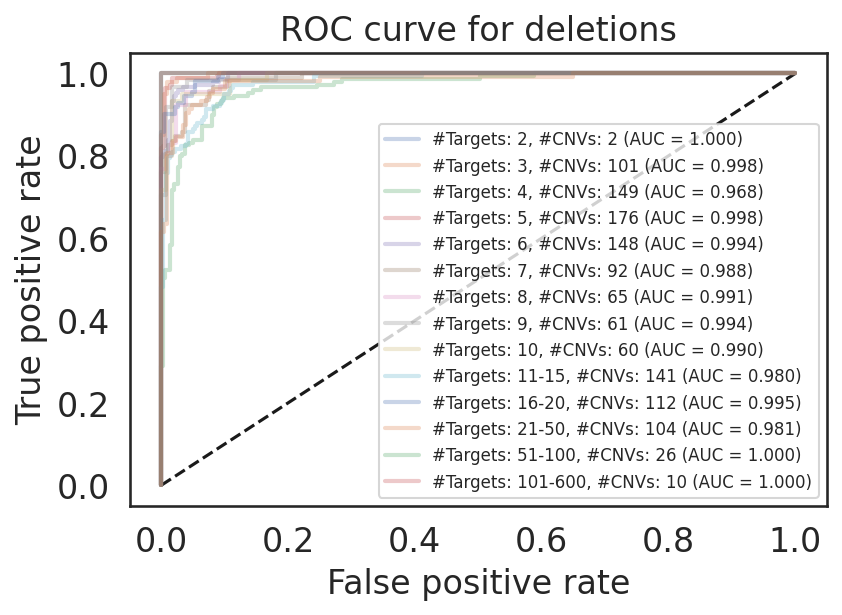

Zoomed ROC curve output plot to: /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/supplementary_figure1a_roc_DEL_w_different_tgs_zoom.pdf


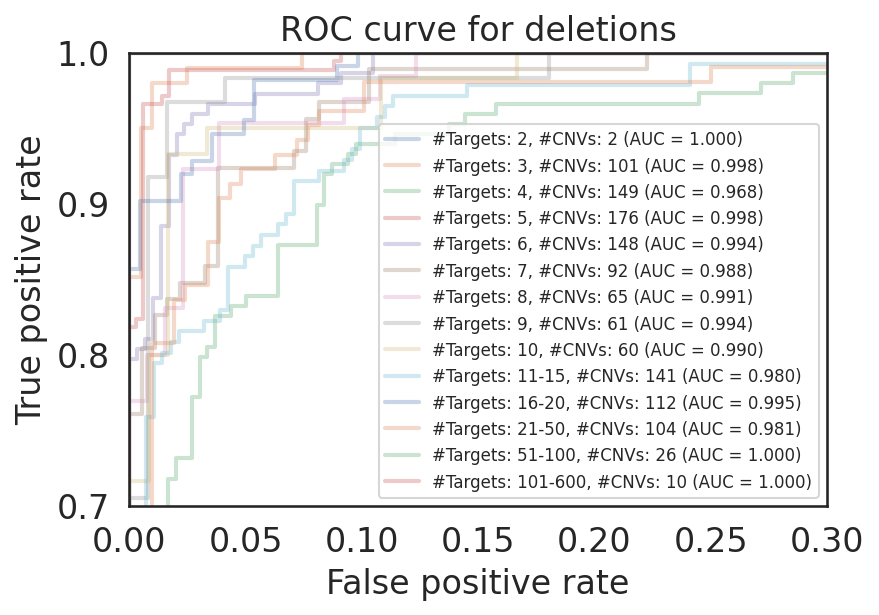

In [111]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)
    
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

output_img_file = figure_path + 'supplementary_figure1a_roc_DEL_w_different_tgs.pdf'
title_content = 'ROC curve for deletions'
func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, title_content = title_content, output_image_file=output_img_file)

- Duplication

Processing num_windows: 2-2 ...
There is/are 9 CNVs with number of targets/windows between 2 and 2.
Processing num_windows: 3-3 ...
There is/are 101 CNVs with number of targets/windows between 3 and 3.
Processing num_windows: 4-4 ...
There is/are 551 CNVs with number of targets/windows between 4 and 4.
Processing num_windows: 5-5 ...
There is/are 491 CNVs with number of targets/windows between 5 and 5.
Processing num_windows: 6-6 ...
There is/are 309 CNVs with number of targets/windows between 6 and 6.
Processing num_windows: 7-7 ...
There is/are 204 CNVs with number of targets/windows between 7 and 7.
Processing num_windows: 8-8 ...
There is/are 150 CNVs with number of targets/windows between 8 and 8.
Processing num_windows: 9-9 ...
There is/are 127 CNVs with number of targets/windows between 9 and 9.
Processing num_windows: 10-10 ...
There is/are 119 CNVs with number of targets/windows between 10 and 10.
Processing num_windows: 11-15 ...
There is/are 374 CNVs with number of targets/w

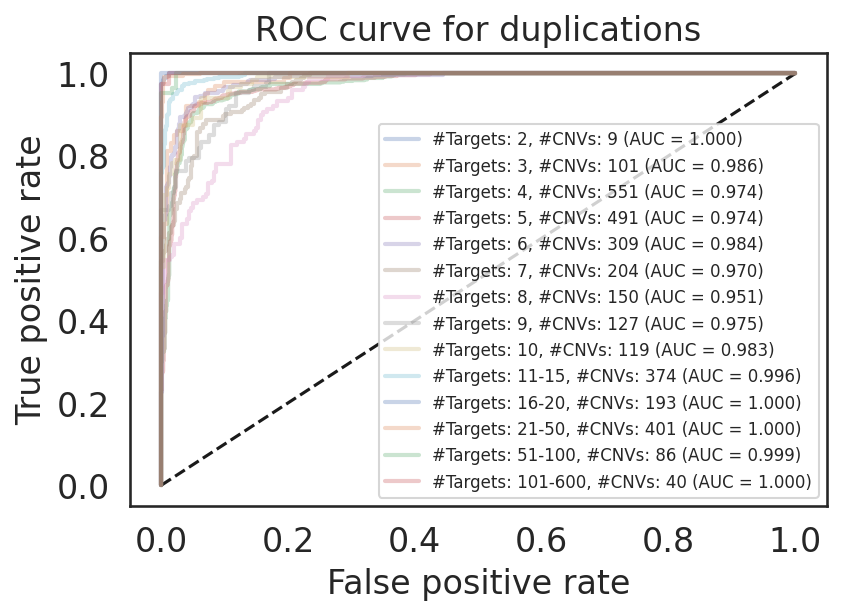

Zoomed ROC curve output plot to: /home/rt2776/cnv_espresso/project0_train_model/logDiffCumX_logY//figures/supplementary_figure1b_roc_DUP_w_different_tgs_zoom.pdf


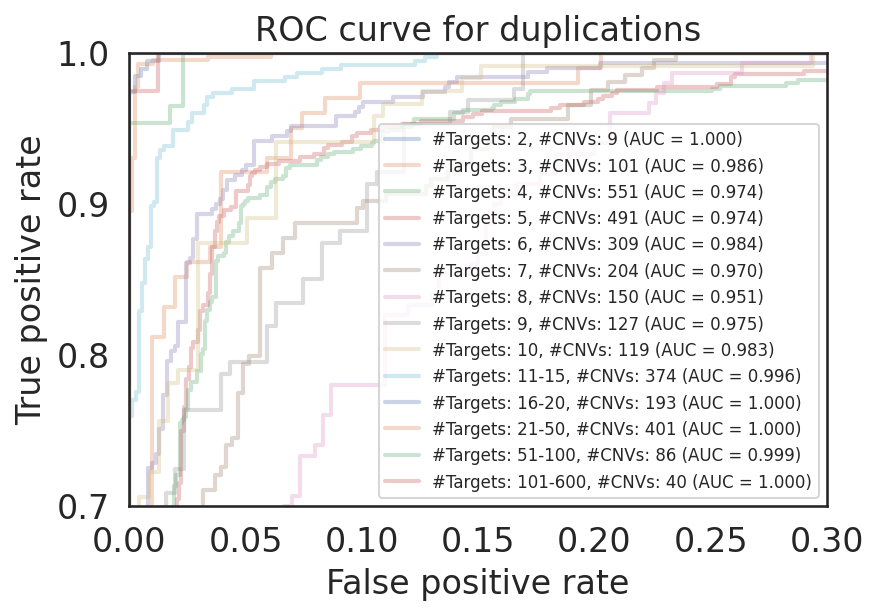

In [112]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)
    
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

output_img_file = figure_path+'supplementary_figure1b_roc_DUP_w_different_tgs.pdf'
title_content   = 'ROC curve for duplications'
func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, title_content = title_content, output_image_file=output_img_file)

### Predict the same test data by split CNV trained model

In [ ]:
split_model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_3classes_MobileNet_v1_3classes_fold3.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}
split_model = keras.models.load_model(split_model_path, custom_objects=custom_objects)

In [ ]:
split_model.evaluate(test_img, test_label)

In [ ]:
test_cnv_info_df.shape, test_img.shape, test_label.shape

In [ ]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(split_model, test_cnv_info_df, test_img, test_label,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)
    
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(split_model, test_cnv_info_df, test_img, test_label,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(split_model, test_cnv_info_df, test_img, test_label,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(split_model, test_cnv_info_df, test_img, test_label,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(split_model, test_cnv_info_df, test_img, test_label,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(split_model, test_cnv_info_df, test_img, test_label,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, output_image_file=None)

- **Deletion and duplication split models**

In [ ]:
test_cnv_info_df.shape, test_img.shape, test_label.shape

In [ ]:
test_cnv_info_df = test_cnv_info_df.reset_index(drop=True)

In [ ]:
test_del_index = test_cnv_info_df[test_cnv_info_df["TYPE"]=='DEL'].index
test_del_cnv_info_df = test_cnv_info_df.iloc[test_del_index]
test_del_img = test_img[test_del_index]
test_del_label = test_label[test_del_index]

test_del_cnv_info_df.shape, test_del_img.shape, test_del_label.shape 

In [ ]:
test_dup_index = test_cnv_info_df[test_cnv_info_df["TYPE"]=='DUP'].index
test_dup_cnv_info_df = test_cnv_info_df.iloc[test_dup_index]
test_dup_img = test_img[test_dup_index]
test_dup_label = test_label[test_dup_index]

test_dup_cnv_info_df.shape, test_dup_img.shape, test_dup_label.shape 

In [ ]:
## Transfer the label from 3 classes to 2 classes.

test_del_list, test_dup_list = [], []
for reader in test_del_label:
    if np.array_equal(reader, [0,1,0]): # when label = 1 in three classes as false del
        test_del_list.append([1,0])     # then transfer to 0 in two classes as false del
    elif np.array_equal(reader, [1,0,0]): # when label = 0 in three classes as true del
        test_del_list.append([0,1])       # then transfer to 1 in two classes as true del
test_del_label_one_hot = np.array(test_del_list)

for reader in test_dup_label:
    if np.array_equal(reader, [0,0,1]): #label=2
        test_dup_list.append([0,1])     # label to 1, true
    elif np.array_equal(reader, [0,1,0]): # when label=1
        test_dup_list.append([1,0])       # transfer to 0, false
test_dup_label_one_hot = np.array(test_dup_list)

In [ ]:
test_dup_label.shape

In [ ]:
test_del_label_one_hot.shape, test_dup_label_one_hot.shape

In [ ]:
## Deletion
split_del_model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_del_2classes_MobileNet_v1_fine-tuning_2classes.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}


model = keras.models.load_model(split_del_model_path, custom_objects=custom_objects)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_del_img, test_del_label_one_hot)

In [ ]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label_one_hot,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)
    
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label_one_hot,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label_one_hot,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label_one_hot,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label_one_hot,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label_one_hot,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, output_image_file=None)

In [ ]:
## Duplication

split_dup_model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_dup_2classes_MobileNet_v1_fine-tuning_2classes.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}


model = keras.models.load_model(split_dup_model_path, custom_objects=custom_objects)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dup_img, test_dup_label_one_hot)

In [ ]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label_one_hot,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)
    
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label_one_hot,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label_one_hot,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label_one_hot,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label_one_hot,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)
test_dup_cnv_info_df
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label_one_hot,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, output_image_file=None)

### Performance on PCGC experimental results 
- move to /home/rt2776/cnv_espresso/src_manuscript/prediction.ipynb

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Sequencial model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- Transfer learning and fine tune: 
    - 讲解：https://zhuanlan.zhihu.com/p/26693647
    - 官方教程：https://www.geek-book.com/src/docs/keras/keras/keras.io/guides/transfer_learning/index.html
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
- F1 score: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model